## **REGRESSION MODELS -including interactions**

In [1]:
# I checked warnings, but for the final report I prefer ignore those 
#that really does not affect the results (warnings of libraries, etc)
import warnings
warnings.simplefilter('ignore')

In [2]:
## **LOAD PACKAGES**

import pandas as pd
import os
from datetime import datetime
import numpy as np

#Sometimes I will use R functions (those I believe are the best ones)
# Load in the r magic
%load_ext rpy2.ipython

In [3]:
# Sometimes I will use R functions (those I believe are the best ones)
# Load in the r magic
%load_ext rpy2.ipython
%R require(ggplot2)
%R require(dplyr)
%R require(data.table)
%R require(cowplot)

# own functions 
%R source('utils/Rgraphs.R')

R[write to console]: Loading required package: ggplot2



The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


R[write to console]: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

R[write to console]: Loading required package: dplyr

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: data.table

R[write to console]: 
Attaching package: ‘data.table’


R[write to console]: The following objects are masked from ‘package:dplyr’:

    between, first, last


R[write to console]: Loading required package: cowplot

R[write to console]: 
********************************************************

R[write to console]: Note: As of version 1.0.0, cowplot does not change the

R[write to console]:   default ggplot2 theme anymore. To recover the previous

R[write t

value,[RTYPES.CLOSXP]
visible,[RTYPES.LGLSXP]


In [4]:
#load treated and aggregated datas
df = pd.read_csv('data/eng_data.csv') 
df_topic = pd.read_csv('data/topic_data.csv') 

In [5]:
df = pd.merge(df, df_topic, on = 'url_title', how = 'left')
print(df.shape)
df = df.select_dtypes(include=[np.int, np.float])
print(df.shape)

(9860, 21)
(9860, 17)


In [6]:
pd.set_option('display.max_rows', 500)
df.dtypes

Sessions             float64
Avg. Time on Page      int64
Bounce Rate          float64
Page Views           float64
Unique Page Views    float64
Users                float64
content_length         int64
month                  int64
mobile                 int64
tablet                 int64
(direct)               int64
goog                   int64
nkedin                 int64
t.co                   int64
spain                  int64
united states          int64
Topic                float64
dtype: object

In [7]:
# result can be used w/ seaborn's heatmap
def compute_correlation_matrix(df, method='pearson'):
    import pandas as pd
    corr_mat = df.corr()
    return corr_mat

import matplotlib.pyplot as plt
import seaborn as sns
cr = compute_correlation_matrix(df)
fig, ax = plt.subplots(figsize=(15,15))
b = sns.heatmap(cr,  vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", annot_kws={"size": 12}, ax= ax, cmap="RdBu_r")
b.tick_params(labelsize=15)
plt.yticks(rotation=45) 
plt.xticks(rotation=45) 

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5]),
 <a list of 17 Text xticklabel objects>)

In [8]:
#topics in other languages
df["Topic"] = pd.to_numeric(df.Topic, errors='coerce').fillna(7).astype(int)
#one hot encoding of topic
df_topic = pd.get_dummies(df['Topic'],drop_first=True, prefix='Topic')
# concatenate data.frames
frames = [df, df_topic]
df = pd.concat(frames, axis = 1) #, sort= True
df = df.drop(columns = ['Topic'])

In [9]:
## eliminate correlated columns
df = df.drop(columns = ['Unique Page Views', 'Users'])

## **LOG TRANSFORMATION**

In [10]:
#log transformations
df['Avg_Time_Page'] = df['Avg. Time on Page']
df['log_Avg_Time_Page'] = np.log(df['Avg_Time_Page'] + 10)
df = df.drop(columns = ['Avg_Time_Page', 'Avg. Time on Page'])

In [11]:
df['log_Avg_Time_Page'].describe()

count    9860.000000
mean        3.257845
std         1.376562
min         2.302585
25%         2.302585
50%         2.302585
75%         4.143135
max         7.501082
Name: log_Avg_Time_Page, dtype: float64

## **CREATE INTERACTIONS**

In [12]:
# Create interaction term (not polynomial features)
df_y = df['log_Avg_Time_Page'] 
df_aux = df.drop(columns = ['log_Avg_Time_Page'])
from sklearn.preprocessing import PolynomialFeatures
interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True) # in degree you can create different levels
X_inter = interaction.fit_transform(df_aux)

In [13]:
df = pd.DataFrame(X_inter)
df.columns = interaction.get_feature_names(df_aux.columns)

In [14]:
# concatenate
frames = [df, df_y]
df = pd.concat(frames, axis = 1) #, sort= True

## **OTHER ALTERNATIVES OF FEATUREING SELECTION**

we can also measure the **MUTUAL INFORMATION** information that exists between the variables and the target (poor/not poor) to select the variables. 

In [15]:
from sklearn.feature_selection import mutual_info_regression
#from sklearn.feature_extraction.text import get_feature_names
Y = df['log_Avg_Time_Page']
X = df.drop(columns = 'log_Avg_Time_Page')
dx = dict(zip(X.columns, mutual_info_regression(X, Y)))
dd = pd.DataFrame(dx, index=[1]).transpose()

R[write to console]: Saving 12.5 x 34.7 in image



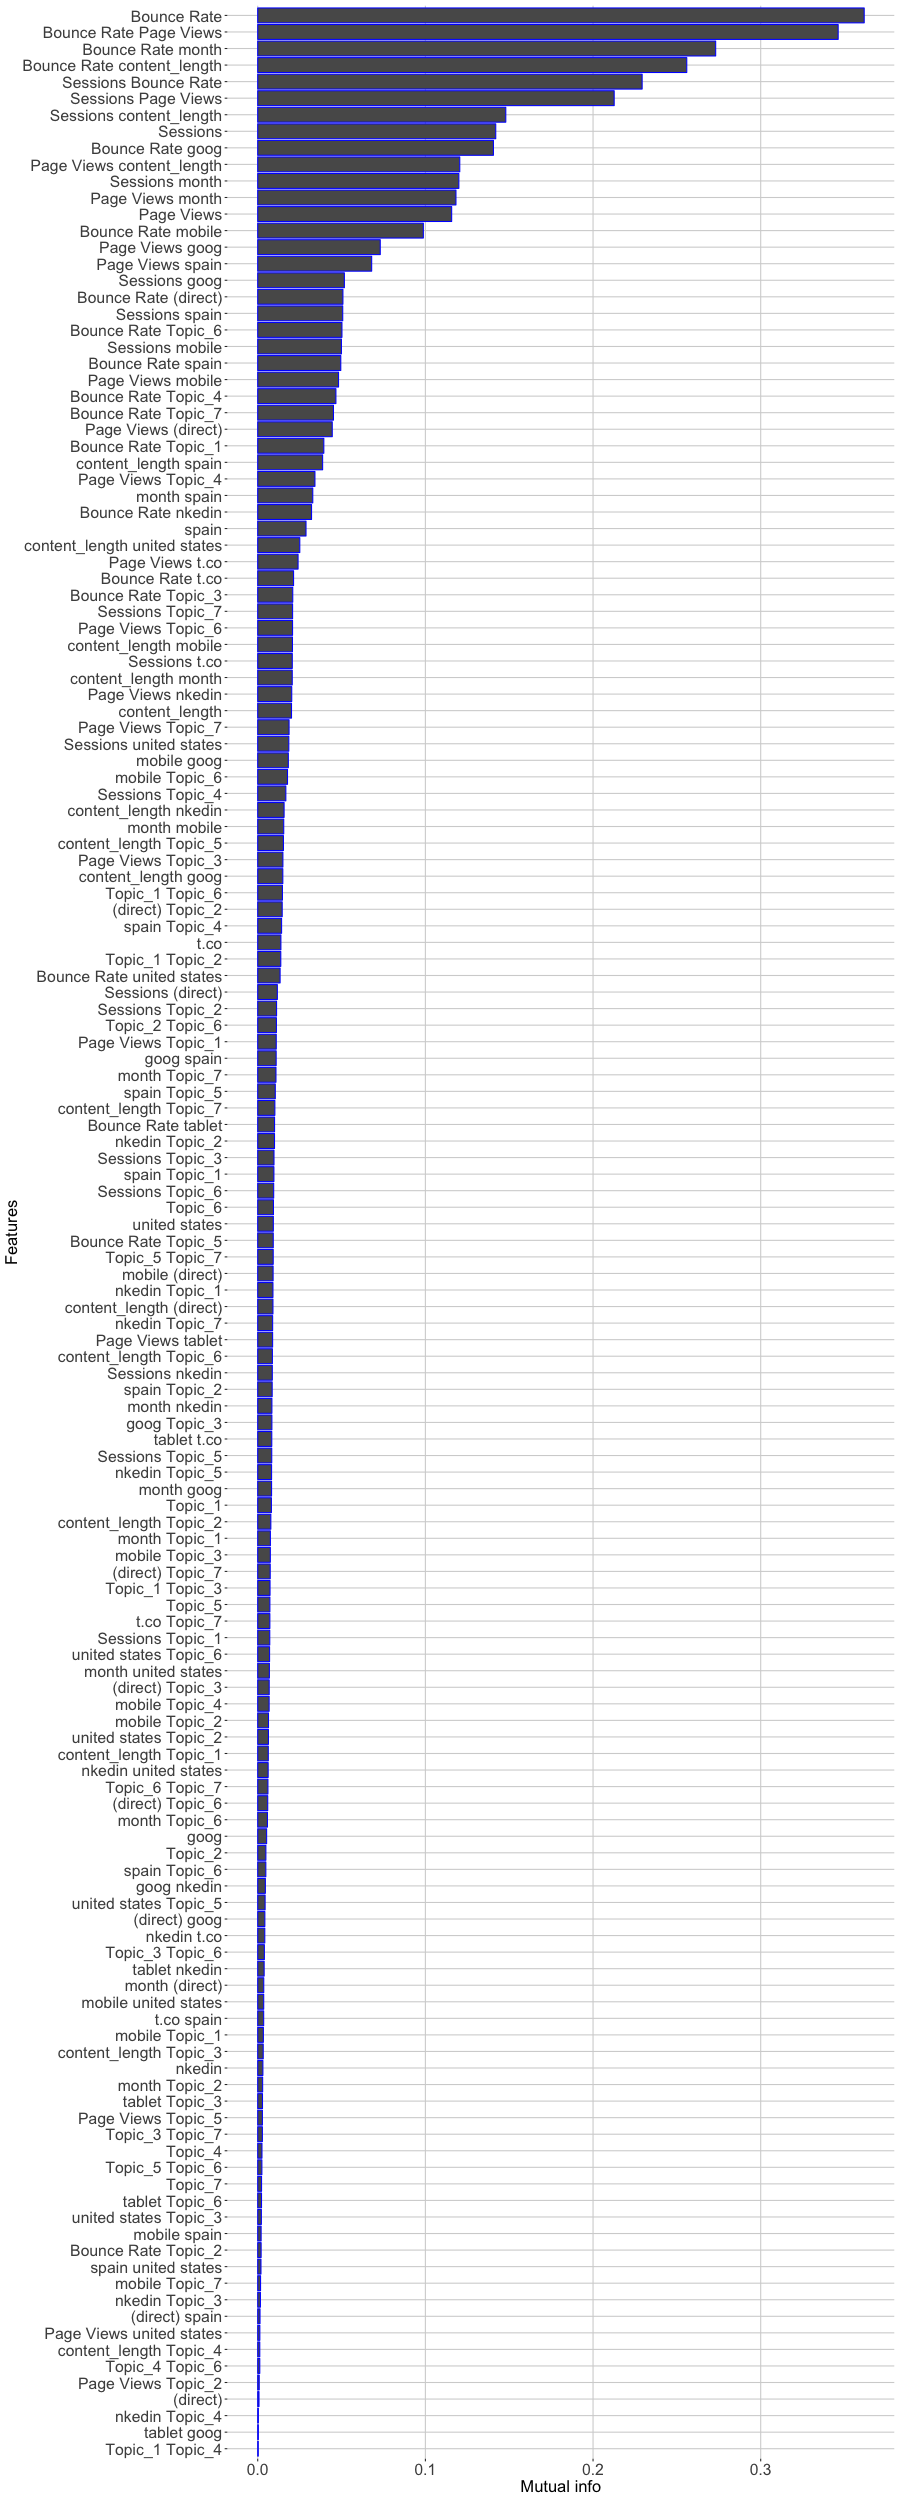

In [16]:
%%R -i dd -w 900 -h 2500 -u px

d = Mutual_info(dd)
print(d)
ggsave('fig/mutual_info_classif.png')

## **DIVISION IN TRAINING AND TEST**

In [17]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)
test_y = test['log_Avg_Time_Page'] 
test = test.drop(columns = ['log_Avg_Time_Page'])

In [18]:
train.head()

,Sessions,Bounce Rate,Page Views,content_length,month,mobile,tablet,(direct),goog,nkedin,...,Topic_3 Topic_5,Topic_3 Topic_6,Topic_3 Topic_7,Topic_4 Topic_5,Topic_4 Topic_6,Topic_4 Topic_7,Topic_5 Topic_6,Topic_5 Topic_7,Topic_6 Topic_7,log_Avg_Time_Page
61,0.0,0.0000,1.0,15966.0,6.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.302585
3961,9.0,0.8889,11.0,3862.0,5.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.717805
151,6.0,0.8333,8.0,3799.0,11.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.477337
3294,1.0,1.0000,1.0,6532.0,11.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.302585
7846,1.0,1.0000,1.0,12373.0,7.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.302585


In [19]:
#missing
missing = (df.isnull().sum(axis = 0)/df.shape[0])*100
missing = missing.apply(pd.to_numeric)
missing= pd.DataFrame(missing)
missing.head()

,0
Sessions,0.0
Bounce Rate,0.0
Page Views,0.0
content_length,0.0
month,0.0


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train, test = train_test_split(df, test_size=0.2)
# Finding normalised array of X_Train
X_std=StandardScaler().fit_transform(train)

(-2, 2)

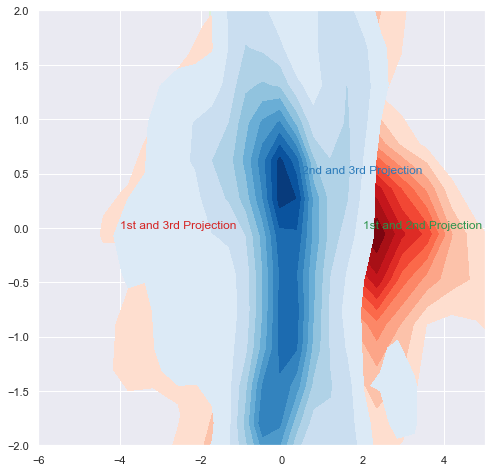

In [21]:
from sklearn.decomposition import PCA
sklearn_pca=PCA(n_components=5)
X_Train=sklearn_pca.fit_transform(X_std)

sns.set(style='darkgrid')
f, ax = plt.subplots(figsize=(8, 8))
# ax.set_aspect('equal')
ax = sns.kdeplot(X_Train[:,0], X_Train[:,1], cmap="Greens",
          shade=True, shade_lowest=False)
ax = sns.kdeplot(X_Train[:,1], X_Train[:,2], cmap="Reds",
          shade=True, shade_lowest=False)
ax = sns.kdeplot(X_Train[:,2], X_Train[:,3], cmap="Blues",
          shade=True, shade_lowest=False)
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
green = sns.color_palette("Greens")[-2]
ax.text(0.5, 0.5, "2nd and 3rd Projection", size=12, color=blue)
ax.text(-4, 0.0, "1st and 3rd Projection", size=12, color=red)
ax.text(2, 0, "1st and 2nd Projection", size=12, color=green)
plt.xlim(-6,5)
plt.ylim(-2,2)

## **REGRESSIONS**

In [22]:
y_train = train['log_Avg_Time_Page'] 
x_train = train.drop(columns = ['log_Avg_Time_Page'])
y_test  = test['log_Avg_Time_Page'] 
x_test  = test.drop(columns = ['log_Avg_Time_Page'])

y_Train=list(y_train)

In [23]:
def error_comparison(y_predict, y_Train, method = 'Ridge', data_t = 'training'):
    
    #transform
    y_predict = np.exp(y_predict) - 10
    y_Train = np.exp(y_Train) - 10
    
    
    error=0
    mae_sum = 0
    mse_sum = 0
    for i in range(len(y_Train)):
        mae_sum += abs(y_Train[i]-y_predict[i])
        error+=(abs(y_Train[i]-y_predict[i])/y_predict[i])
        mse_sum += (y_Train[i]-y_predict[i])**2
    train_error_ridge= 100 - error/len(y_Train)*100
    mae = mae_sum/len(y_Train)
    rmse = np.sqrt(mse_sum/len(y_Train))
    #print(data_t + " error = "'{}'.format(train_error_ridge)+" mape percent in " + method + " Regression")
    print(data_t + " error = "'{}'.format(mae)+" mae in " + method + "Regression")
    print(data_t + " error = "'{}'.format(rmse)+" rmse in " + method + "Regression")

    return train_error_ridge, mae, rmse

## **Modelling**

In [24]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

## **RIDGE**

In [25]:
from sklearn import linear_model
from sklearn.pipeline import Pipeline

In [26]:
# RANDON SEARCH
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

print("-- Random Parameter Search via 10-fold CV")

# dict of parameter list/distributions to sample
param_dist = { "fit_intercept": ["True", "False"],
                  "alpha": range(1, 15),
                  "solver": ["auto", "svd", "cholesky", "lsqr"], 
                  "normalize": ["True", "False"]
             }
ridge = linear_model.Ridge()
ridge_cv = RandomizedSearchCV(ridge, param_dist, cv=10)
X = ridge_cv.fit(x_train,y_train)

-- Random Parameter Search via 10-fold CV


In [27]:
print(ridge_cv.best_score_)
print(ridge_cv.best_params_)
print(ridge_cv.best_estimator_)

0.21390920111801937
{'solver': 'auto', 'normalize': 'True', 'fit_intercept': 'False', 'alpha': 2}
Ridge(alpha=2, copy_X=True, fit_intercept='False', max_iter=None,
   normalize='True', random_state=None, solver='auto', tol=0.001)


In [28]:
model = Pipeline([('scaler', StandardScaler()),
                  #('ridge', linear_model.Ridge(solver= "lsqr", normalize= 'True', fit_intercept= 'False', alpha= 7))
                  ('ridge', linear_model.Ridge(solver= "auto", normalize= 'True', fit_intercept= 'False', alpha= 2))
                 ])
#model = Pipeline([('scaler', StandardScaler()),
#                  ('ridge', linear_model.Ridge(**ridge_cv.best_params_))
#                 ])

In [29]:
model.fit(x_train,y_train)
y_predict=model.predict(x_train)

ridge_percent, ridge_mae, ridge_mse = error_comparison(y_predict, y_Train)

training error = 84.29992532573416 mae in RidgeRegression
training error = 246.20260786040487 rmse in RidgeRegression


[[1.         0.51001808]
 [0.51001808 1.        ]]


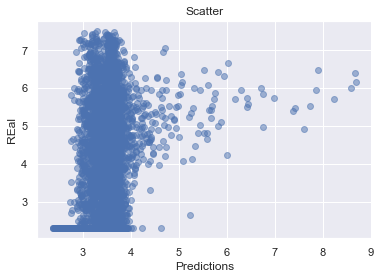

In [30]:
print(np.corrcoef(y_predict, y_Train))
# Plot
plt.scatter(y_predict, y_Train, alpha=0.5)
plt.title('Scatter')
plt.xlabel('Predictions')
plt.ylabel('REal')
plt.show()

In [31]:
cols = x_train.columns
coef = pd.DataFrame(model.named_steps['ridge'].coef_)
coef['names'] = cols
coef.columns = ['weights', 'names']

R[write to console]: Saving 12.5 x 34.7 in image



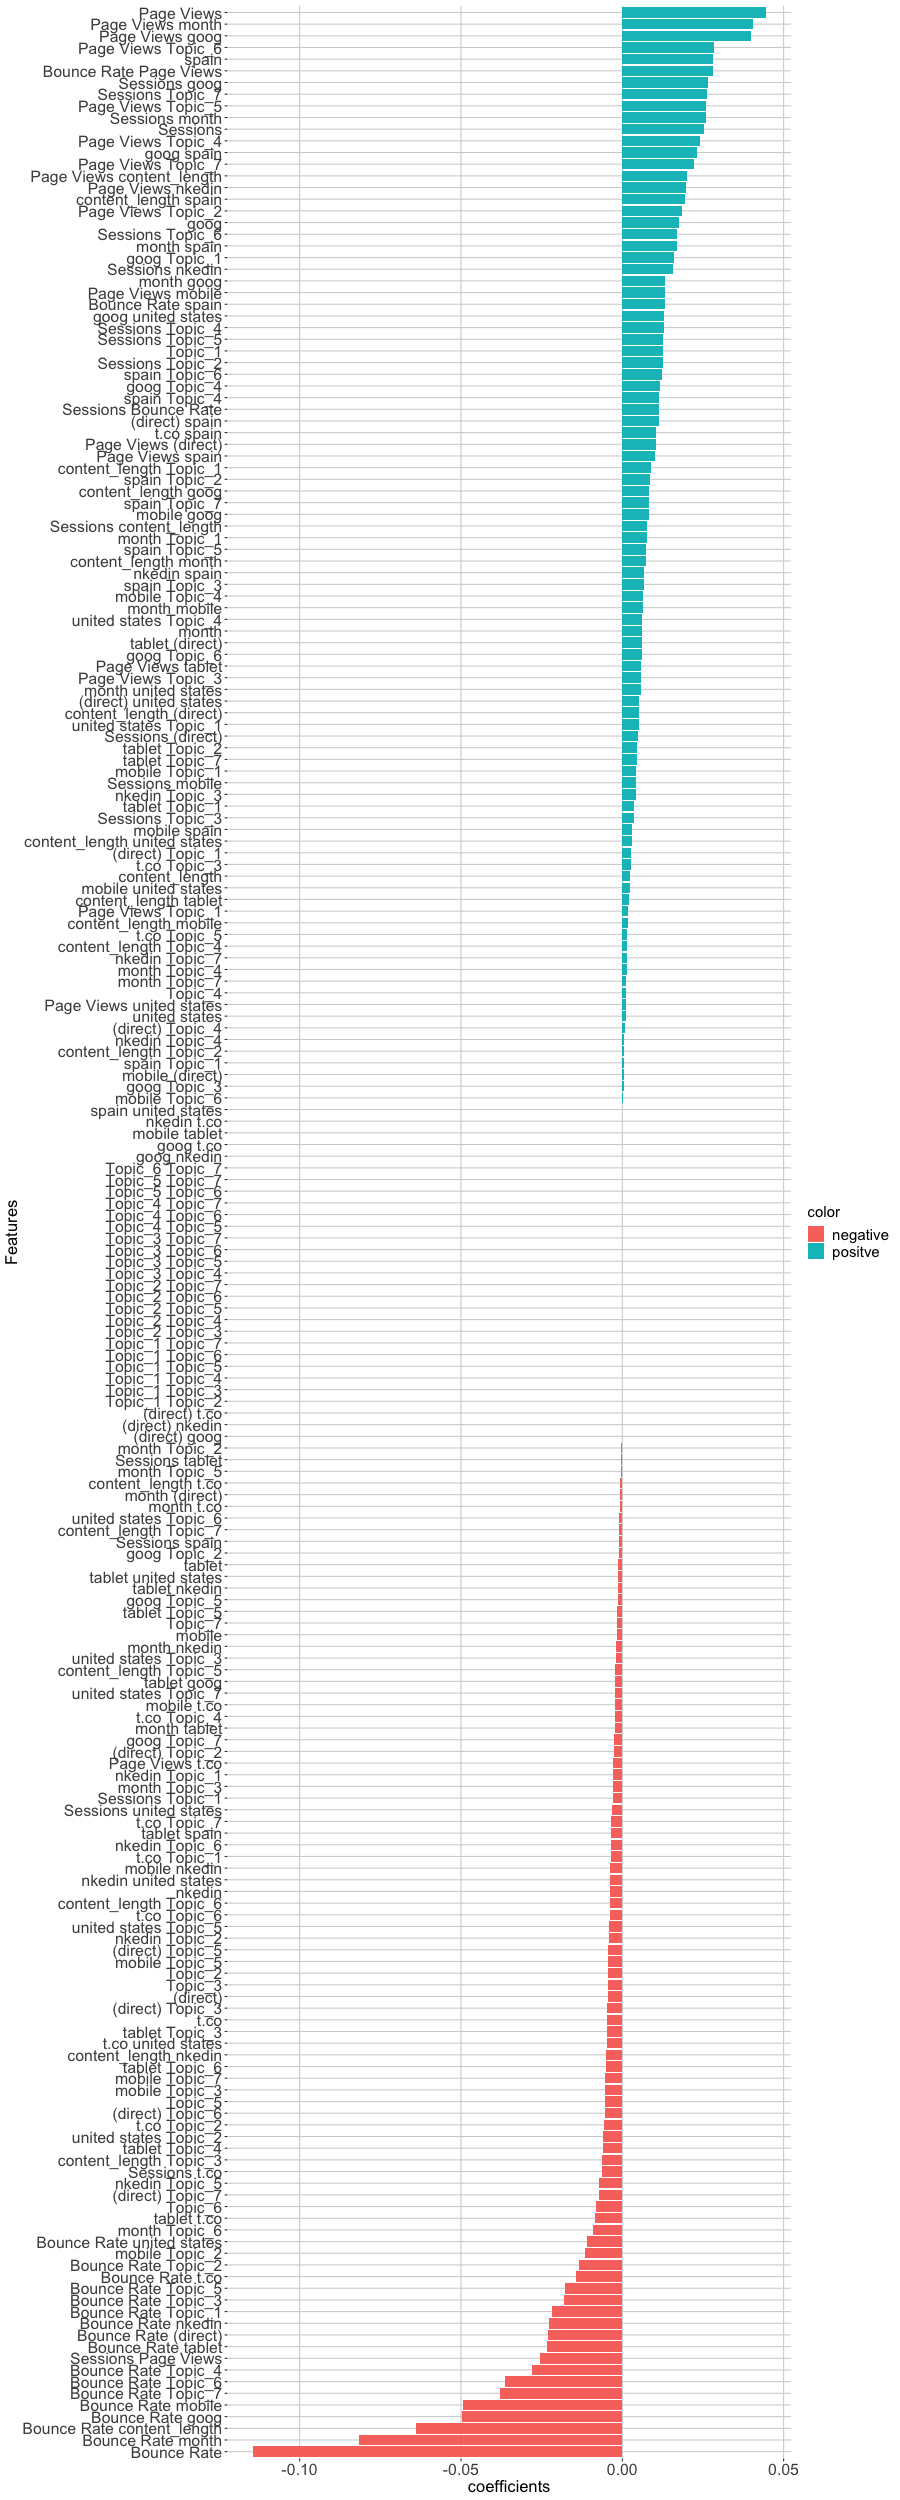

In [32]:
%%R -i coef -w 900 -h 2500 -u px

dt.values = as.data.table(coef)
names(dt.values) = c( 'value', 'Var1')
dt.values = dt.values[order(value, decreasing = T),]
dt.values = dt.values %>% mutate(color = ifelse(value <= 0,  'negative', 'positve'))

d <- ggplot(dt.values, aes(y = value, x = reorder(Var1, value), fill = color)) +  geom_bar(stat = "identity") + coord_flip()
d <- d + ylab('coefficients') + xlab('Features') 
  #d <- d +  theme_tq() 
d <- d + theme(axis.title.y = element_text(size = rel(1.5)))
d <- d + theme(axis.text.y = element_text(size = rel(1.8)))
d <- d + theme(axis.text.x = element_text(size = rel(1.8)))
d <- d + theme(axis.title.x = element_text(size = rel(1.5)))
d <- d + theme(legend.text = element_text(size = 15))
d <- d + theme(legend.title = element_text(size = 15))
d <- d +  theme(
    panel.background = element_rect(fill="white") ,
    panel.grid.minor.y = element_line(size=3),
    panel.grid.major = element_line(colour = "lightgray"),
    plot.background = element_rect(fill="white")
  )

ggsave('fig/ridge_importance.png')
d

In [33]:
y_Predict=model.predict(x_test)
Y_test=list(y_test)

t_ridge_percent, t_ridge_mae, t_ridge_mse = error_comparison(y_Predict, Y_test, method = 'Ridge', data_t = 'test')

test error = 396.9888237540637 mae in RidgeRegression
test error = 13845.443362793372 rmse in RidgeRegression


[[1.         0.45893515]
 [0.45893515 1.        ]]


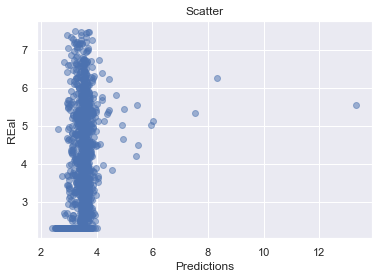

In [34]:
print(np.corrcoef(y_Predict, Y_test))
# Plot
plt.scatter(y_Predict, Y_test, alpha=0.5)
plt.title('Scatter')
plt.xlabel('Predictions')
plt.ylabel('REal')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Residual plot in Ridge Regression')

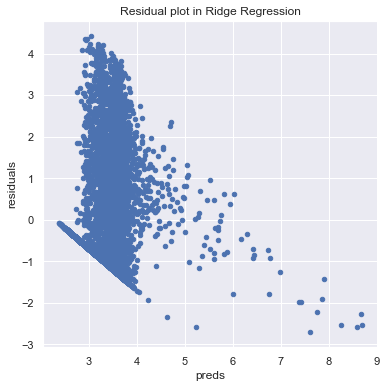

In [35]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model.predict(x_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Ridge Regression")

## **Knn Algorithm**

In [36]:
from sklearn.pipeline import Pipeline
from sklearn import neighbors

In [37]:
print("-- Random Parameter Search via 10-fold CV")

# dict of parameter list/distributions to sample
param_dist = {"algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
              "leaf_size": randint(10, 50),
              "n_neighbors": randint(1, 5),
              "weights": ["uniform", "distance"],
              "p": randint(1, 4),
              
             }
neighbors = neighbors.KNeighborsRegressor()
neighbors_cv = RandomizedSearchCV(neighbors, param_dist, cv=10)
X = neighbors_cv.fit(x_train,y_train)


-- Random Parameter Search via 10-fold CV


In [38]:
print(neighbors_cv.best_score_)
print(neighbors_cv.best_params_)
print(neighbors_cv.best_estimator_)

0.27892285155001506
{'algorithm': 'kd_tree', 'leaf_size': 24, 'n_neighbors': 4, 'p': 3, 'weights': 'uniform'}
KNeighborsRegressor(algorithm='kd_tree', leaf_size=24, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=4, p=3,
          weights='uniform')


In [39]:
from sklearn import neighbors
knn = Pipeline([('scaler', StandardScaler()),
                 #('knn', neighbors.KNeighborsRegressor(n_neighbors = 4,weights='uniform'))
                ('knn', neighbors.KNeighborsRegressor(n_neighbors = 4, p = 3, weights='uniform', algorithm= "kd_tree", leaf_size =  24))
               ])
#knn = Pipeline([('scaler', StandardScaler()),
#                  ('knn', 'knn', neighbors.KNeighborsRegressor(**neighbors_cv.best_params_))
#                 ])

In [40]:
knn.fit(x_train,y_train)
y1_knn=knn.predict(x_train)

knn_percent, knn_mae, knn_mse  = error_comparison(y1_knn, y_Train, method = 'Knn', data_t = 'training')

training error = 66.77343465659658 mae in KnnRegression
training error = 190.43621917868947 rmse in KnnRegression


In [41]:
y2_knn=knn.predict(x_test)
y2_knn=list(y2_knn)
t_knn_percent, t_knn_mae, t_knn_mse = error_comparison(y2_knn, Y_test, method = 'Knn', data_t = 'test')

test error = 80.4738009216952 mae in KnnRegression
test error = 218.41379846043677 rmse in KnnRegression


[[1.         0.53388384]
 [0.53388384 1.        ]]


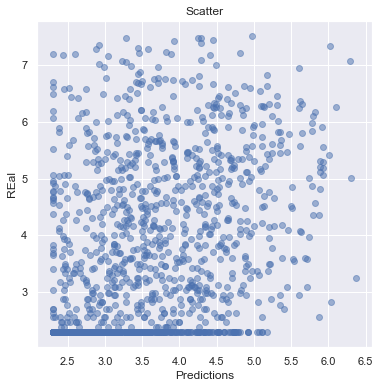

In [42]:
print(np.corrcoef(y2_knn, Y_test))
# Plot
plt.scatter(y2_knn, Y_test, alpha=0.5)
plt.title('Scatter')
plt.xlabel('Predictions')
plt.ylabel('REal')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Residual plot in Knn')

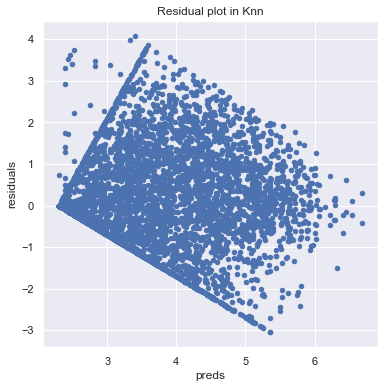

In [43]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":knn.predict(x_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Knn")

## **Bayesian Regression**

In [44]:
from sklearn import linear_model
from sklearn.pipeline import Pipeline

In [45]:
distribution = [i/1e5 for i in range (1,100)]

In [46]:
# RANDON SEARCH

print("-- Random Parameter Search via 10-fold CV")

# dict of parameter list/distributions to sample
param_dist = {"fit_intercept": [True, False],
               "normalize" : [True, False],
                  "alpha_1": distribution,
                  "alpha_2": distribution,
                  "lambda_1": distribution,
                  "lambda_2": distribution
                  
             }
bayes = linear_model.BayesianRidge()
bayes_cv = RandomizedSearchCV(bayes, param_dist, cv=10)
X = bayes_cv.fit(x_train,y_train)

-- Random Parameter Search via 10-fold CV


In [47]:
print(bayes_cv.best_score_)
print(bayes_cv.best_params_)
print(bayes_cv.best_estimator_)

0.28910506829202637
{'normalize': True, 'lambda_2': 0.00023, 'lambda_1': 0.00011, 'fit_intercept': True, 'alpha_2': 0.00021, 'alpha_1': 0.00086}
BayesianRidge(alpha_1=0.00086, alpha_2=0.00021, compute_score=False,
       copy_X=True, fit_intercept=True, lambda_1=0.00011, lambda_2=0.00023,
       n_iter=300, normalize=True, tol=0.001, verbose=False)


In [48]:
'''
from sklearn import linear_model
from sklearn.pipeline import Pipeline
reg = Pipeline([('scaler', StandardScaler()),
                  ('bayes', linear_model.BayesianRidge())])
reg.fit(x_train,y_train)
'''

"\nfrom sklearn import linear_model\nfrom sklearn.pipeline import Pipeline\nreg = Pipeline([('scaler', StandardScaler()),\n                  ('bayes', linear_model.BayesianRidge())])\nreg.fit(x_train,y_train)\n"

In [49]:
reg = linear_model.BayesianRidge(normalize= True, lambda_2= 0.00099, lambda_1 = 0.00096, fit_intercept = True, alpha_2 =0.00028, alpha_1= 0.00058)
reg.fit(x_train,y_train)
y1_reg=reg.predict(x_train)
y1_reg=list(y1_reg)
y2_reg=reg.predict(x_test)
y2_reg=list(y2_reg)

In [50]:
bayes_percent, bayes_mae, bayes_mse = error_comparison(y1_reg, y_Train, method = 'Bayes', data_t = 'training')

training error = 86.27892149821074 mae in BayesRegression
training error = 346.12249373307503 rmse in BayesRegression


In [51]:
y2_reg=reg.predict(x_test)
y2_reg=list(y2_reg)

In [52]:
t_bayes_percent, t_bayes_mae, t_bayes_mse = error_comparison(y2_reg, Y_test, method = 'Bayes', data_t = 'test')

test error = 99.7130199175773 mae in BayesRegression
test error = 549.1434572459852 rmse in BayesRegression


[[1.         0.48223686]
 [0.48223686 1.        ]]


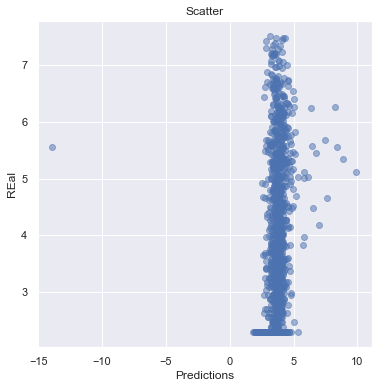

In [53]:
print(np.corrcoef(y2_reg, Y_test))
# Plot
plt.scatter(y2_reg, Y_test, alpha=0.5)
plt.title('Scatter')
plt.xlabel('Predictions')
plt.ylabel('REal')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Residual plot in Bayesian Regression')

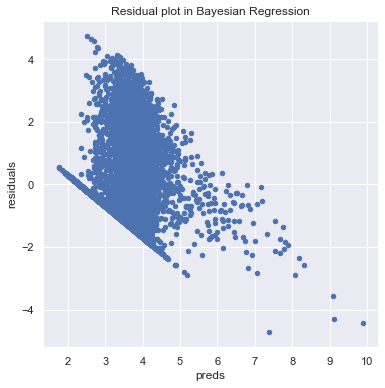

In [54]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":reg.predict(x_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Bayesian Regression")

In [55]:
x_train.head()

,Sessions,Bounce Rate,Page Views,content_length,month,mobile,tablet,(direct),goog,nkedin,...,Topic_3 Topic_4,Topic_3 Topic_5,Topic_3 Topic_6,Topic_3 Topic_7,Topic_4 Topic_5,Topic_4 Topic_6,Topic_4 Topic_7,Topic_5 Topic_6,Topic_5 Topic_7,Topic_6 Topic_7
9172,0.0,0.0,3.0,2519.0,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6526,1.0,1.0,1.0,8560.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9168,0.0,0.0,5.0,2519.0,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7306,0.0,0.0,1.0,11303.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2036,4.0,1.0,4.0,4463.0,2.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **Decision Tree Regressor**

In [56]:
from sklearn import tree
dec = tree.DecisionTreeRegressor(max_depth=1)
dec.fit(x_train,y_train)
y1_dec=dec.predict(x_train)
y1_dec=list(y1_dec)
y2_dec=dec.predict(x_test)
y2_dec=list(y2_dec)

In [57]:
dt_percent, dt_mae, dt_mse = error_comparison(y1_dec, y_Train, method = 'Decision Tree', data_t = 'training')
t_dt_percent, t_dt_mae, t_dt_mse = error_comparison(y2_dec, Y_test, method = 'Decision', data_t = 'test')

training error = 78.04969740064743 mae in Decision TreeRegression
training error = 208.54231178921938 rmse in Decision TreeRegression
test error = 79.39396707116526 mae in DecisionRegression
test error = 220.12731812723496 rmse in DecisionRegression


[[1.         0.60709152]
 [0.60709152 1.        ]]


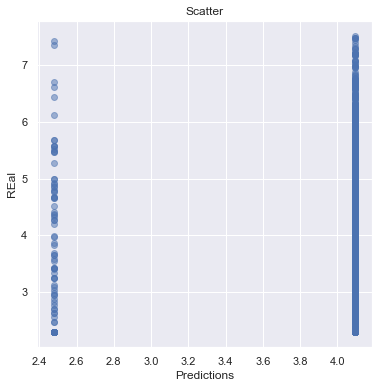

In [58]:
print(np.corrcoef(y2_dec, Y_test))
# Plot
plt.scatter(y2_dec, Y_test, alpha=0.5)
plt.title('Scatter')
plt.xlabel('Predictions')
plt.ylabel('REal')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Residual plot in Decision Tree')

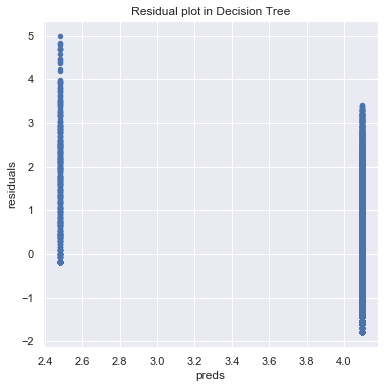

In [59]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":dec.predict(x_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Decision Tree")

## **SVM**

In [60]:
from sklearn import svm
from sklearn.pipeline import Pipeline

In [61]:

'''
# RANDON SEARCH
print("-- Random Parameter Search via 10-fold CV")

# dict of parameter list/distributions to sample
param_dist = { #"shrinking": [True, False],
               #   "C": randint(1, 5),
                  "tol": distribution  
             }
sv = svm.SVR(kernel='linear')
sv_cv = RandomizedSearchCV(sv, param_dist, cv= 5)
X = sv_cv.fit(x_train,y_train)

print(sv_cv.best_score_)
print(sv_cv.best_params_)
print(sv_cv.best_estimator_)
'''

'\n# RANDON SEARCH\nprint("-- Random Parameter Search via 10-fold CV")\n\n# dict of parameter list/distributions to sample\nparam_dist = { #"shrinking": [True, False],\n               #   "C": randint(1, 5),\n                  "tol": distribution  \n             }\nsv = svm.SVR(kernel=\'linear\')\nsv_cv = RandomizedSearchCV(sv, param_dist, cv= 5)\nX = sv_cv.fit(x_train,y_train)\n\nprint(sv_cv.best_score_)\nprint(sv_cv.best_params_)\nprint(sv_cv.best_estimator_)\n'

In [62]:
model = Pipeline([('scaler', StandardScaler()),
                  ('svr', svm.SVR(kernel='linear', max_iter = 10000,  tol=0.01))])
model.fit(x_train,y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=10000, shrinking=True, tol=0.01, verbose=False))])

In [63]:
y1_svm=model.predict(x_train)
y1_svm=list(y1_svm)
y2_svm=model.predict(x_test)
y2_svm=list(y2_svm)

## **IMPORTANCE svm**

In [64]:
#model.named_steps['svr'].coef_

In [65]:
cols = x_train.columns
coef = pd.DataFrame(model.named_steps['svr'].coef_)
coef.columns = cols
coef = coef.transpose()

R[write to console]: Saving 12.5 x 27.8 in image



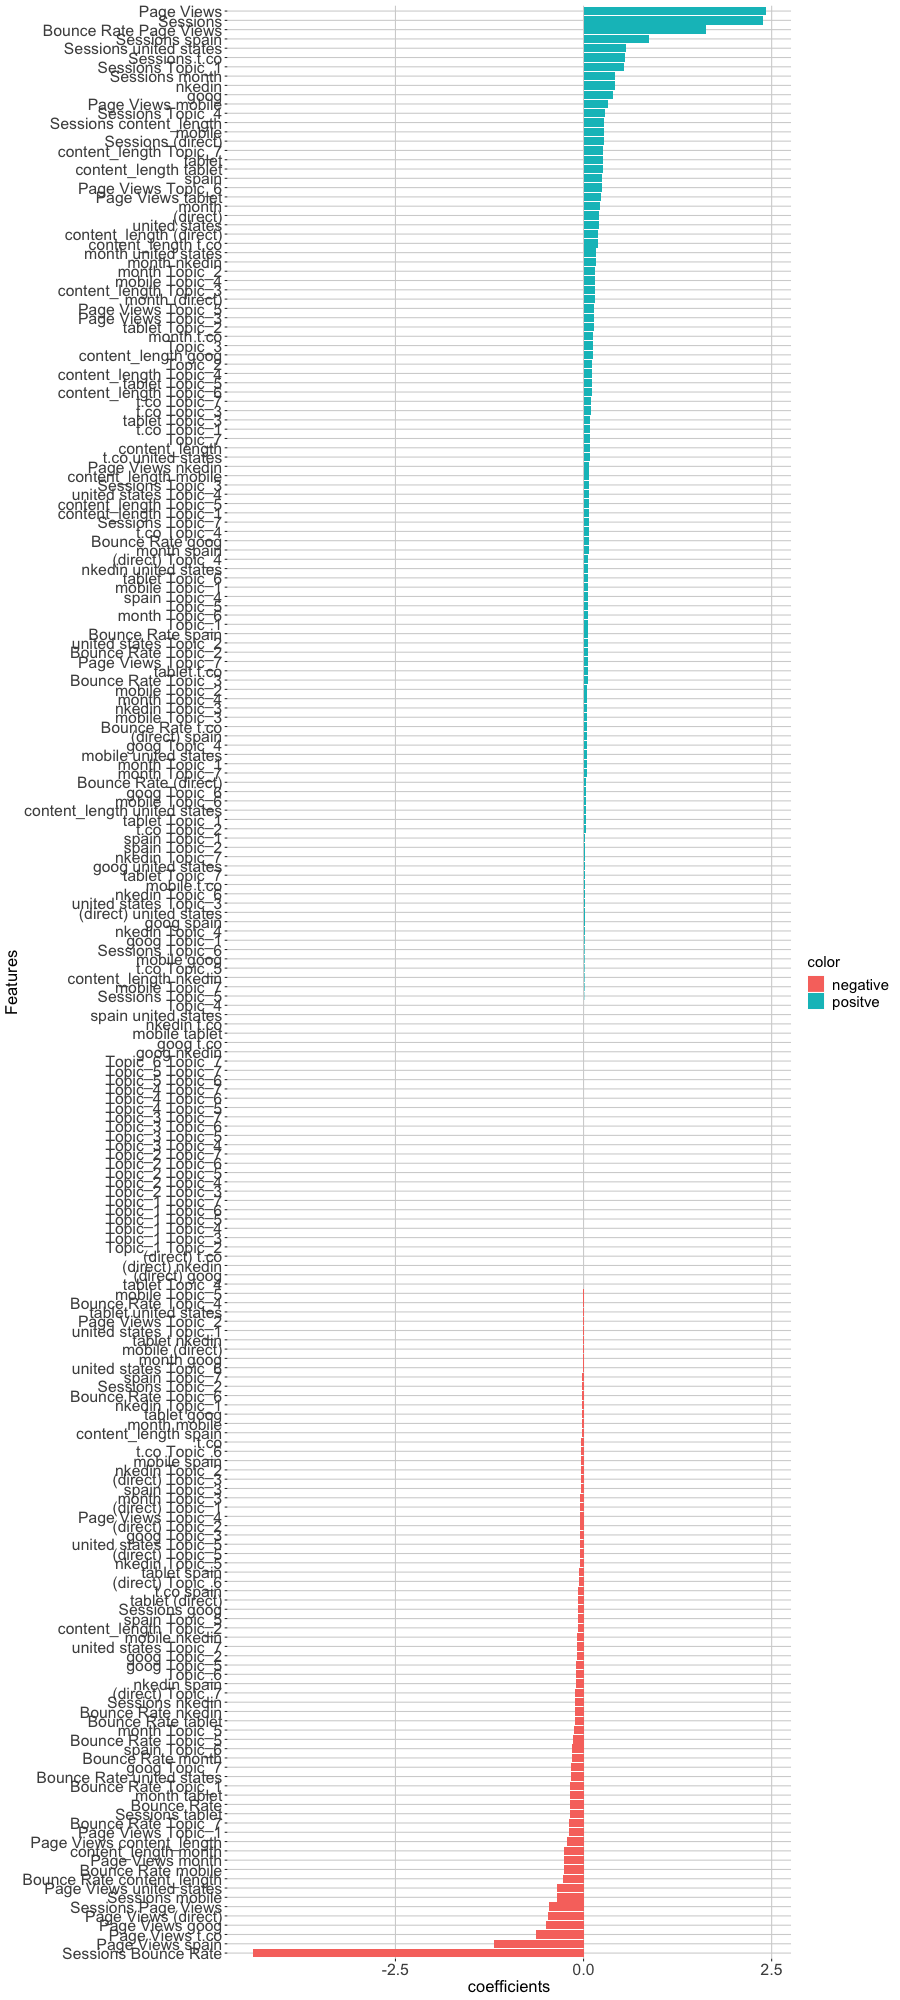

In [66]:
%%R -i coef -w 900 -h 2000 -u px

dt.values = as.data.table(cbind(row.names(coef), coef), row.names = NULL)
names(dt.values) = c('Var1', 'value')
dt.values = dt.values[order(value, decreasing = T),]
dt.values = dt.values %>% mutate(color = ifelse(value <= 0,  'negative', 'positve'))

d <- ggplot(dt.values, aes(y = value, x = reorder(Var1, value), fill = color)) +  geom_bar(stat = "identity") + coord_flip()
d <- d + ylab('coefficients') + xlab('Features') 
  #d <- d +  theme_tq() 
d <- d + theme(axis.title.y = element_text(size = rel(1.5)))
d <- d + theme(axis.text.y = element_text(size = rel(1.8)))
d <- d + theme(axis.text.x = element_text(size = rel(1.8)))
d <- d + theme(axis.title.x = element_text(size = rel(1.5)))
d <- d + theme(legend.text = element_text(size = 15))
d <- d + theme(legend.title = element_text(size = 15))
d <- d +  theme(
    panel.background = element_rect(fill="white") ,
    panel.grid.minor.y = element_line(size=3),
    panel.grid.major = element_line(colour = "lightgray"),
    plot.background = element_rect(fill="white")
  )

ggsave('fig/svm_importance.png')
d

In [67]:
svm_percent, svm_mae, svm_mse = error_comparison(y1_svm, y_Train, method = 'SVM', data_t = 'training')

training error = 1735879231100161.8 mae in SVMRegression
training error = 1.1681574862421125e+17 rmse in SVMRegression


In [68]:
t_svm_percent, t_svm_mae, t_svm_mse = error_comparison(y2_svm, Y_test, method = 'SVM', data_t = 'test')

test error = 1991157.516774136 mae in SVMRegression
test error = 47607356.88832423 rmse in SVMRegression


[[1.         0.40206481]
 [0.40206481 1.        ]]


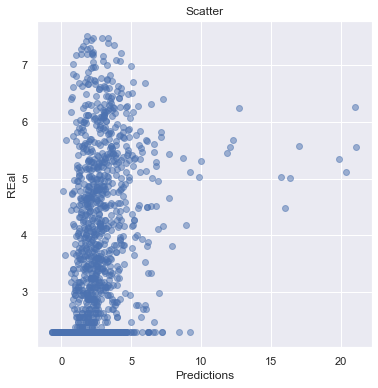

In [69]:
print(np.corrcoef(y2_svm, Y_test))
# Plot
plt.scatter(y2_svm, Y_test, alpha=0.5)
plt.title('Scatter')
plt.xlabel('Predictions')
plt.ylabel('REal')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Residual plot in SVM')

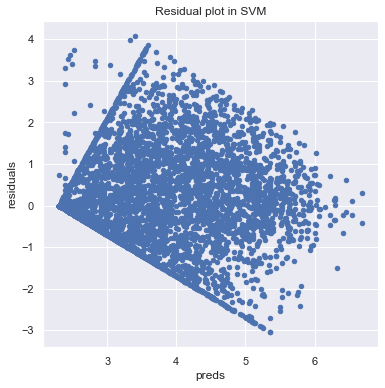

In [70]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":knn.predict(x_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in SVM")

## **xgboost**

In [71]:
import xgboost as xgb

In [72]:
# RANDON SEARCH

print("-- Random Parameter Search via 10-fold CV")

# dict of parameter list/distributions to sample
param_dist = {
        'silent': [False],
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100]}

xb = xgb.XGBRegressor(objective ='reg:squarederror')
xgb_cv = RandomizedSearchCV(xb, param_dist, cv=10)
X = xgb_cv.fit(x_train,y_train)

-- Random Parameter Search via 10-fold CV


In [73]:
print(xgb_cv.best_score_)
print(xgb_cv.best_params_)
print(xgb_cv.best_estimator_)

0.5353650197515666
{'subsample': 0.7, 'silent': False, 'reg_lambda': 50.0, 'n_estimators': 100, 'min_child_weight': 7.0, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.25, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0.25,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=7.0, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=50.0, scale_pos_weight=1,
       seed=None, silent=False, subsample=0.7, verbosity=1)


In [74]:

#data_dmatrix = xgb.DMatrix(data=X,label=y)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',subsample = 0.7, 
                          silent = False, reg_lambda = 50.0, n_estimators = 100, 
                          min_child_weight = 7.0, max_depth = 6, learning_rate = 0.1, 
                          gamma = 0.25, colsample_bytree = 0.9, colsample_bylevel = 0.9)

xg_reg.fit(x_train,y_train)
y1_xg = xg_reg.predict(x_train)
y2_xg = xg_reg.predict(x_test)

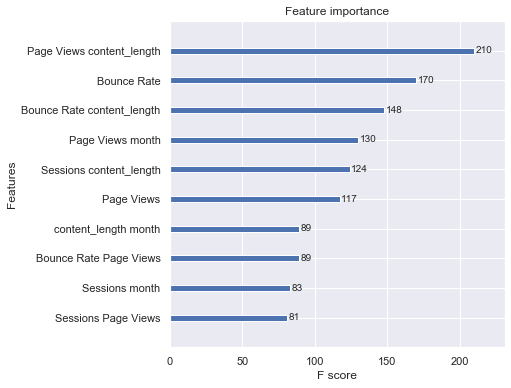

In [75]:
from xgboost import plot_importance
plot_importance(xg_reg, max_num_features=10) # top 10 most important features

## **ERRORS**

In [76]:
xgb_percent, xgb_mae, xgb_mse = error_comparison(y1_xg, y_Train, method = 'xgb', data_t = 'training')
t_xgb_percent, t_xgb_mae, t_xgb_mse = error_comparison(y2_xg, Y_test, method = 'xgb', data_t = 'test')

training error = 64.68687176232889 mae in xgbRegression
training error = 189.62093919466295 rmse in xgbRegression
test error = 71.52885098583074 mae in xgbRegression
test error = 208.47392019771345 rmse in xgbRegression


[[1.         0.74014871]
 [0.74014871 1.        ]]


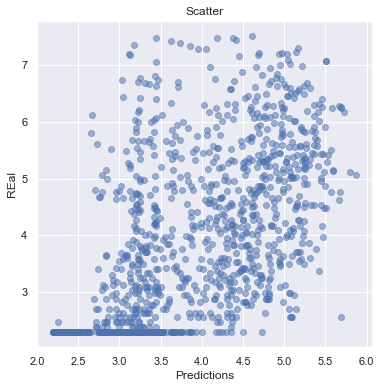

In [77]:
print(np.corrcoef(y2_xg, Y_test))
# Plot
plt.scatter(y2_xg, Y_test, alpha=0.5)
plt.title('Scatter')
plt.xlabel('Predictions')
plt.ylabel('REal')
plt.show()

## **COMPARISONS**

## **MAE**

In [78]:
from pandas import DataFrame,Series

train_error= [ridge_mae, knn_mae, dt_mae, xgb_mae] # svm_mae,
test_error= [t_ridge_mae, t_knn_mae, t_dt_mae,  t_xgb_mae] #t_svm_mae,

col={'Train Error':train_error,'Test Error':test_error}
models=['Ridge Regression','Knn','Decision Tree', 'xgb'] #'SVM',
df_error=DataFrame(data=col,index=models)
df_error


,Train Error,Test Error
Ridge Regression,84.299925,396.988824
Knn,66.773435,80.473801
Decision Tree,78.049697,79.393967
xgb,64.686872,71.528851


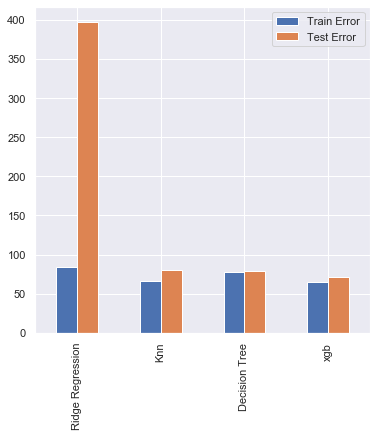

In [79]:
df_error.plot(kind='bar')

In [80]:
## RMSE
train_error= [ridge_mse, knn_mse,  dt_mse,  xgb_mse] #svm_mse,
test_error= [t_ridge_mse, t_knn_mse,  t_dt_mse, t_xgb_mse] # t_svm_mse,

col={'Train Error':train_error,'Test Error':test_error}
models=['Ridge Regression','Knn','Decision Tree', 'xgb'] #'SVM',
df_error=DataFrame(data=col,index=models)
df_error

,Train Error,Test Error
Ridge Regression,246.202608,13845.443363
Knn,190.436219,218.413798
Decision Tree,208.542312,220.127318
xgb,189.620939,208.473920


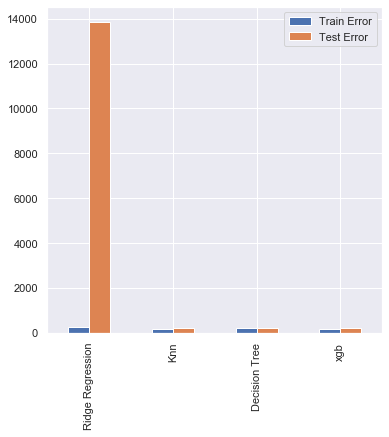

In [81]:
df_error.plot(kind='bar')

## **DENSITY**

In [82]:
from pandas import DataFrame
df_results = DataFrame(y2_xg,columns= ['xgb'])
df_results['real_test'] = Y_test
df_results['ridge'] =y_Predict
df_results['knn'] =y2_knn
df_results['dt'] =y2_dec
df_results['svm'] =y2_svm
df_results.shape

df_results['id']=df_results.index

df_results_melt = pd.melt(df_results, id_vars =['id'])

In [83]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


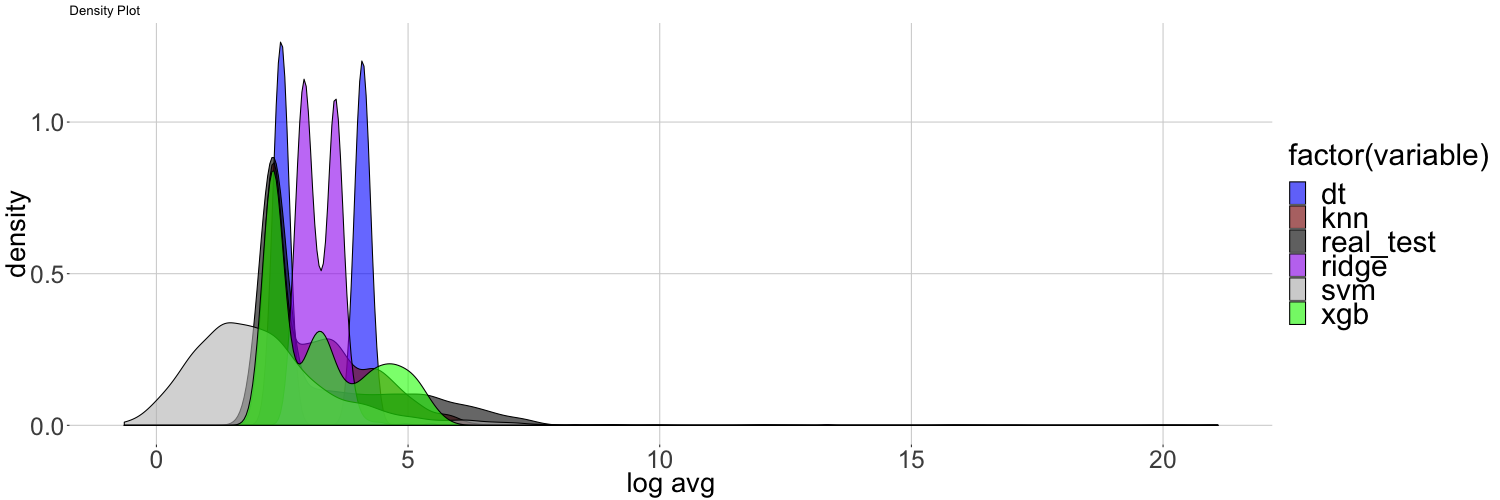

In [86]:
%%R -i df_results_melt -w 1500 -h 500 -u px
d = ggplot(df_results_melt, aes(x=value, fill=factor(variable))) + geom_density(alpha = .6) + 
  labs(title="Density Plot", x="log avg")
#d <- d + theme_tq() 
d <- d + theme(axis.title.y = element_text(size = rel(2.5)))
d <- d + theme(axis.text.y = element_text(size = rel(2.8)))
d <- d + theme(axis.text.x = element_text(size = rel(2.8)))
d <- d + theme(axis.title.x = element_text(size = rel(2.5)))
d <- d + theme(legend.text = element_text(size = 30))
d <- d + theme(legend.title = element_text(size = 30))
d <- d +  theme(
        panel.background = element_rect(fill="white") ,
        panel.grid.minor.y = element_line(size=3),
        panel.grid.major = element_line(colour = "lightgray"),
        plot.background = element_rect(fill="white")
      )

d <- d + scale_fill_manual(values=c("blue", "darkred", "black", "purple", "gray",
                                   "green"))
d